In [3]:
import os
import matplotlib.pyplot as plt
import sklearn as sk
import numpy as np
import pandas as pd
import time
import math
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import seaborn as sns

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
df1 = pd.read_csv('/content/drive/MyDrive/시계열분석/서울시 대기질 자료 제공_2008-2011.csv',encoding='cp949')
df2 = pd.read_csv('/content/drive/MyDrive/시계열분석/서울시 대기질 자료 제공_2012-2015.csv',encoding='cp949')
df3 = pd.read_csv('/content/drive/MyDrive/시계열분석/서울시 대기질 자료 제공_2016-2019.csv',encoding='cp949')
df4 = pd.read_csv('/content/drive/MyDrive/시계열분석/서울시 대기질 자료 제공_2020-2021.csv',encoding='cp949')

In [326]:
df = pd.concat([df1,df2,df3,df4]).fillna(0)
df_avg = df[df['구분']== '평균']
df_avg

,일시,구분,미세먼지(PM10),초미세먼지(PM25)
0,2011-12-31 23:00,평균,89.0,61.0
26,2011-12-31 22:00,평균,104.0,71.0
52,2011-12-31 21:00,평균,104.0,69.0
78,2011-12-31 20:00,평균,97.0,64.0
104,2011-12-31 19:00,평균,97.0,64.0
...,...,...,...,...
322476,2020-01-01 4:00,평균,23.0,15.0
322502,2020-01-01 3:00,평균,25.0,16.0
322528,2020-01-01 2:00,평균,24.0,15.0
322554,2020-01-01 1:00,평균,24.0,16.0


In [327]:
df_avg.index = pd.to_datetime(df_avg['일시'])
df_avg.index

DatetimeIndex(['2011-12-31 23:00:00', '2011-12-31 22:00:00',
               '2011-12-31 21:00:00', '2011-12-31 20:00:00',
               '2011-12-31 19:00:00', '2011-12-31 18:00:00',
               '2011-12-31 17:00:00', '2011-12-31 16:00:00',
               '2011-12-31 15:00:00', '2011-12-31 14:00:00',
               ...
               '2020-01-01 09:00:00', '2020-01-01 08:00:00',
               '2020-01-01 07:00:00', '2020-01-01 06:00:00',
               '2020-01-01 05:00:00', '2020-01-01 04:00:00',
               '2020-01-01 03:00:00', '2020-01-01 02:00:00',
               '2020-01-01 01:00:00', '2020-01-01 00:00:00'],
              dtype='datetime64[ns]', name='일시', length=117597, freq=None)

In [328]:
pd.date_range("2008-1-1-01", "2021-5-31-23", freq="H")

DatetimeIndex(['2008-01-01 01:00:00', '2008-01-01 02:00:00',
               '2008-01-01 03:00:00', '2008-01-01 04:00:00',
               '2008-01-01 05:00:00', '2008-01-01 06:00:00',
               '2008-01-01 07:00:00', '2008-01-01 08:00:00',
               '2008-01-01 09:00:00', '2008-01-01 10:00:00',
               ...
               '2021-05-31 14:00:00', '2021-05-31 15:00:00',
               '2021-05-31 16:00:00', '2021-05-31 17:00:00',
               '2021-05-31 18:00:00', '2021-05-31 19:00:00',
               '2021-05-31 20:00:00', '2021-05-31 21:00:00',
               '2021-05-31 22:00:00', '2021-05-31 23:00:00'],
              dtype='datetime64[ns]', length=117599, freq='H')

In [329]:
complement = list(set(pd.date_range("2008-1-1-01", "2021-5-31-23", freq="H")) - set(df_avg.index))
print( complement )

[Timestamp('2015-09-03 12:00:00', freq='H'), Timestamp('2015-08-24 00:00:00', freq='H')]


In [330]:
df_extra = pd.concat([df_avg[df_avg.index == '2008-01-01 01:00:00'], df_avg[df_avg.index == '2015-09-03 13:00:00'],df_avg[df_avg.index == '2015-08-24 01:00:00']])
df_extra = df_extra.drop(['일시'], axis=1)
df_extra_id = pd.to_datetime(['2008-01-01 00:00:00', '2015-09-03 12:00:00', '2015-08-24 00:00:00'])
df_extra.index = df_extra_id
df_extra

,구분,미세먼지(PM10),초미세먼지(PM25)
2008-01-01 00:00:00,평균,59.0,14.0
2015-09-03 12:00:00,평균,18.0,11.0
2015-08-24 00:00:00,평균,40.0,25.0


In [331]:
df_avg = df_avg.drop(['일시'], axis=1)
df_avg2 = pd.concat([df_avg, df_extra])
df_avg2.sort_index(ascending=True, inplace = True)
df_avg2 = df_avg2.drop(['구분'], axis=1)
df_avg2.rename(columns={'미세먼지(PM10)' : 'Fine_Dust(PM10)', '초미세먼지(PM25)' : 'Ultrafine_Dust(PM25)'}, inplace= True)
df_avg2

,Fine_Dust(PM10),Ultrafine_Dust(PM25)
2008-01-01 00:00:00,59.0,14.0
2008-01-01 01:00:00,59.0,14.0
2008-01-01 02:00:00,52.0,14.0
2008-01-01 03:00:00,49.0,14.0
2008-01-01 04:00:00,45.0,15.0
...,...,...
2021-05-31 19:00:00,45.0,25.0
2021-05-31 20:00:00,45.0,25.0
2021-05-31 21:00:00,45.0,25.0
2021-05-31 22:00:00,43.0,23.0


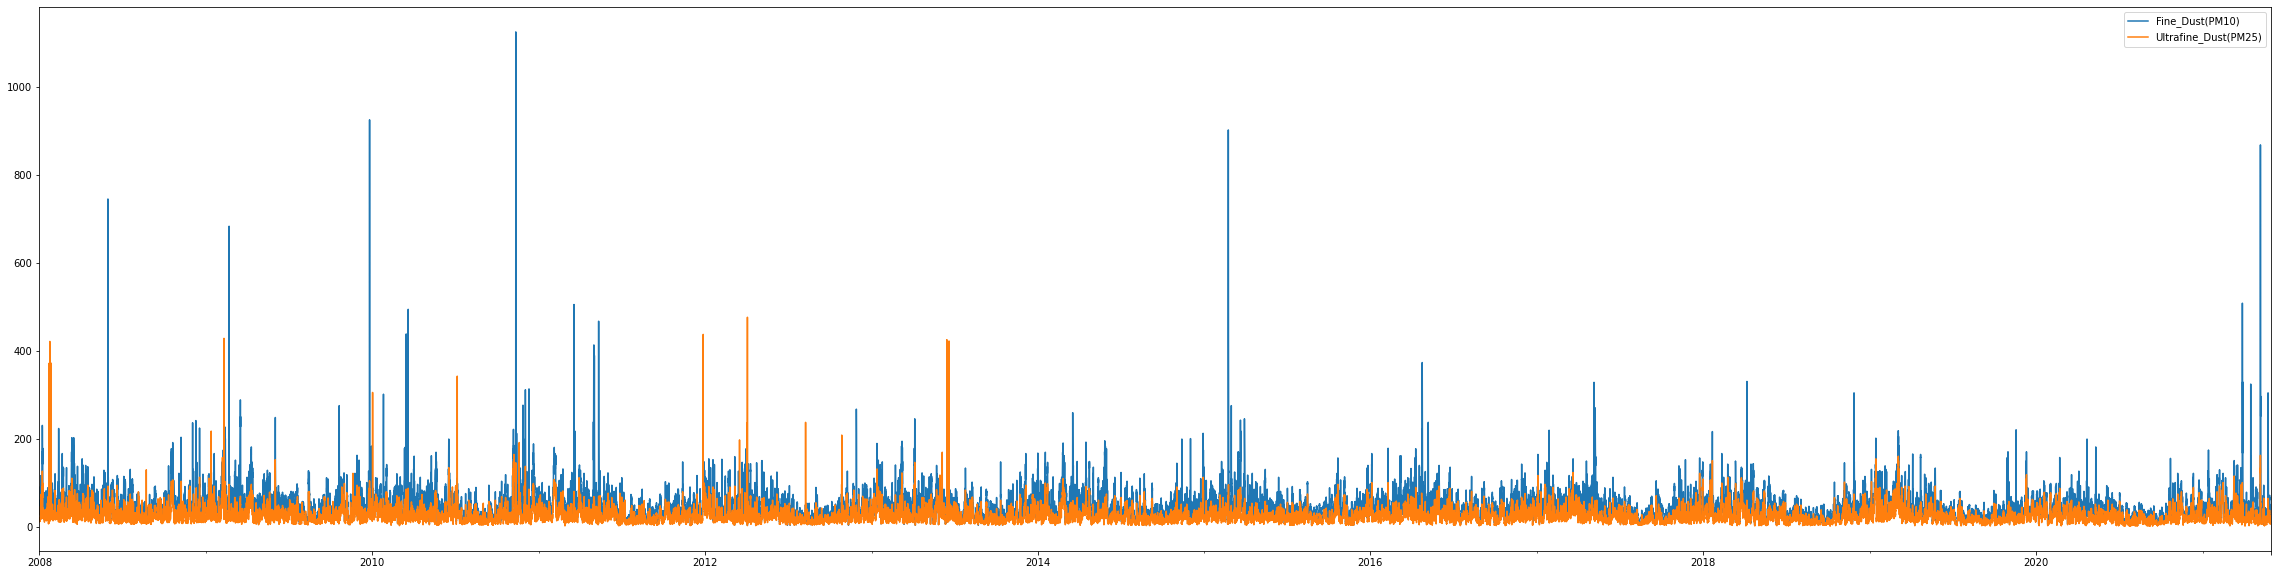

In [332]:
df_avg2.plot(figsize=(40,10))

In [333]:
daily_df = df_avg2.resample('D').mean()
daily_df

,Fine_Dust(PM10),Ultrafine_Dust(PM25)
2008-01-01,37.833333,13.208333
2008-01-02,35.708333,16.000000
2008-01-03,54.333333,25.625000
2008-01-04,84.583333,41.250000
2008-01-05,66.250000,29.916667
...,...,...
2021-05-27,40.333333,17.791667
2021-05-28,39.708333,21.125000
2021-05-29,20.416667,10.666667
2021-05-30,24.791667,12.708333


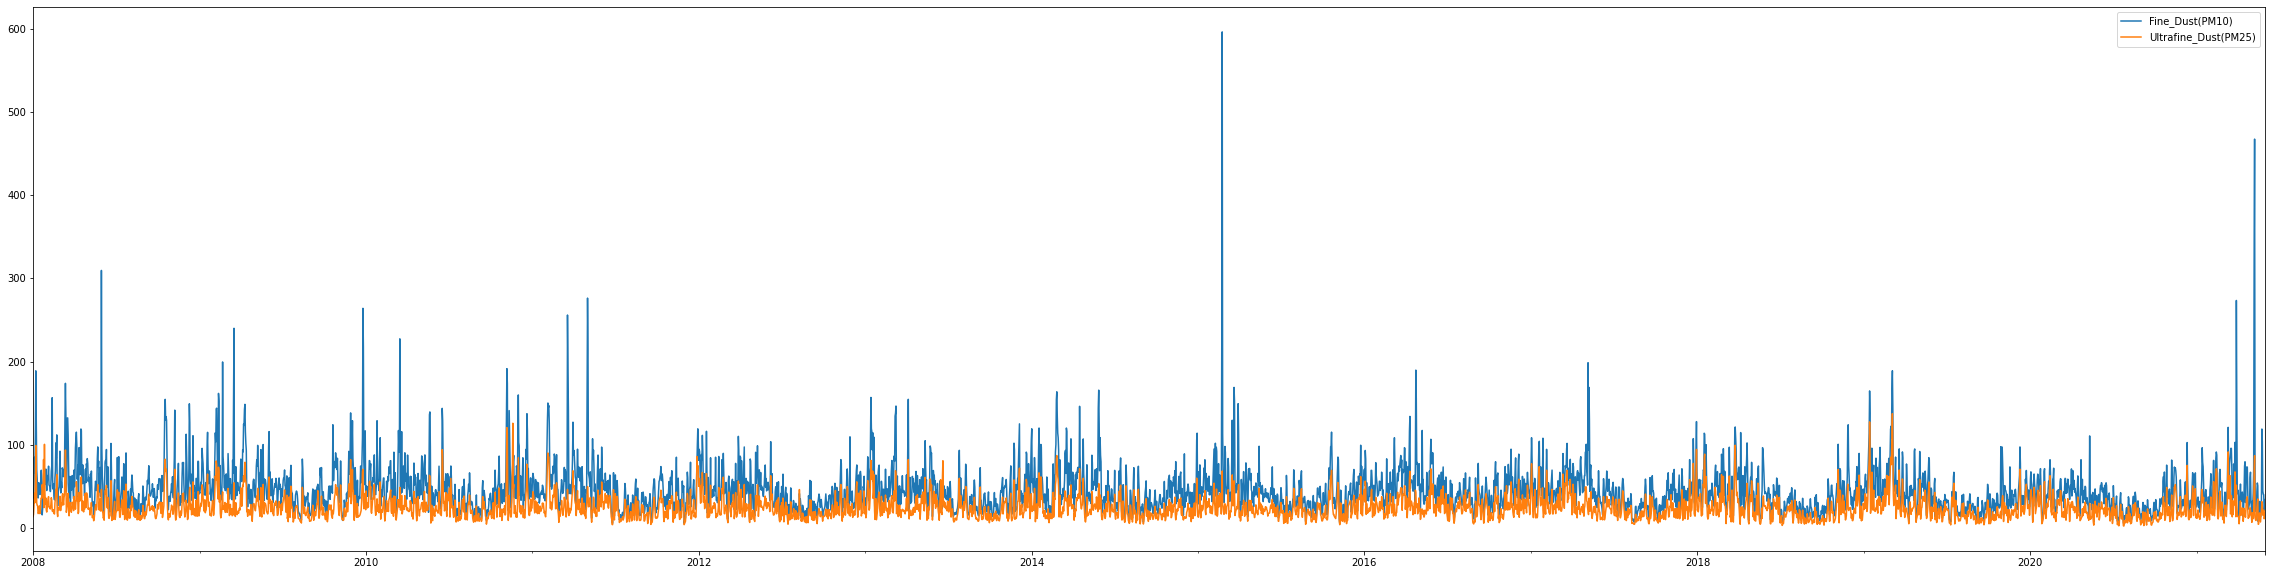

In [334]:
daily_df.plot(figsize=(40,10))

In [335]:
monthly_df = df_avg2.resample('M').mean()
monthly_df

,Fine_Dust(PM10),Ultrafine_Dust(PM25)
2008-01-31,60.908602,36.702957
2008-02-29,62.609195,27.833333
2008-03-31,70.224462,32.842742
2008-04-30,72.926389,34.063889
2008-05-31,60.973118,24.801075
...,...,...
2021-01-31,37.612903,21.077957
2021-02-28,47.941964,29.354167
2021-03-31,66.463710,32.194892
2021-04-30,41.663889,18.568056


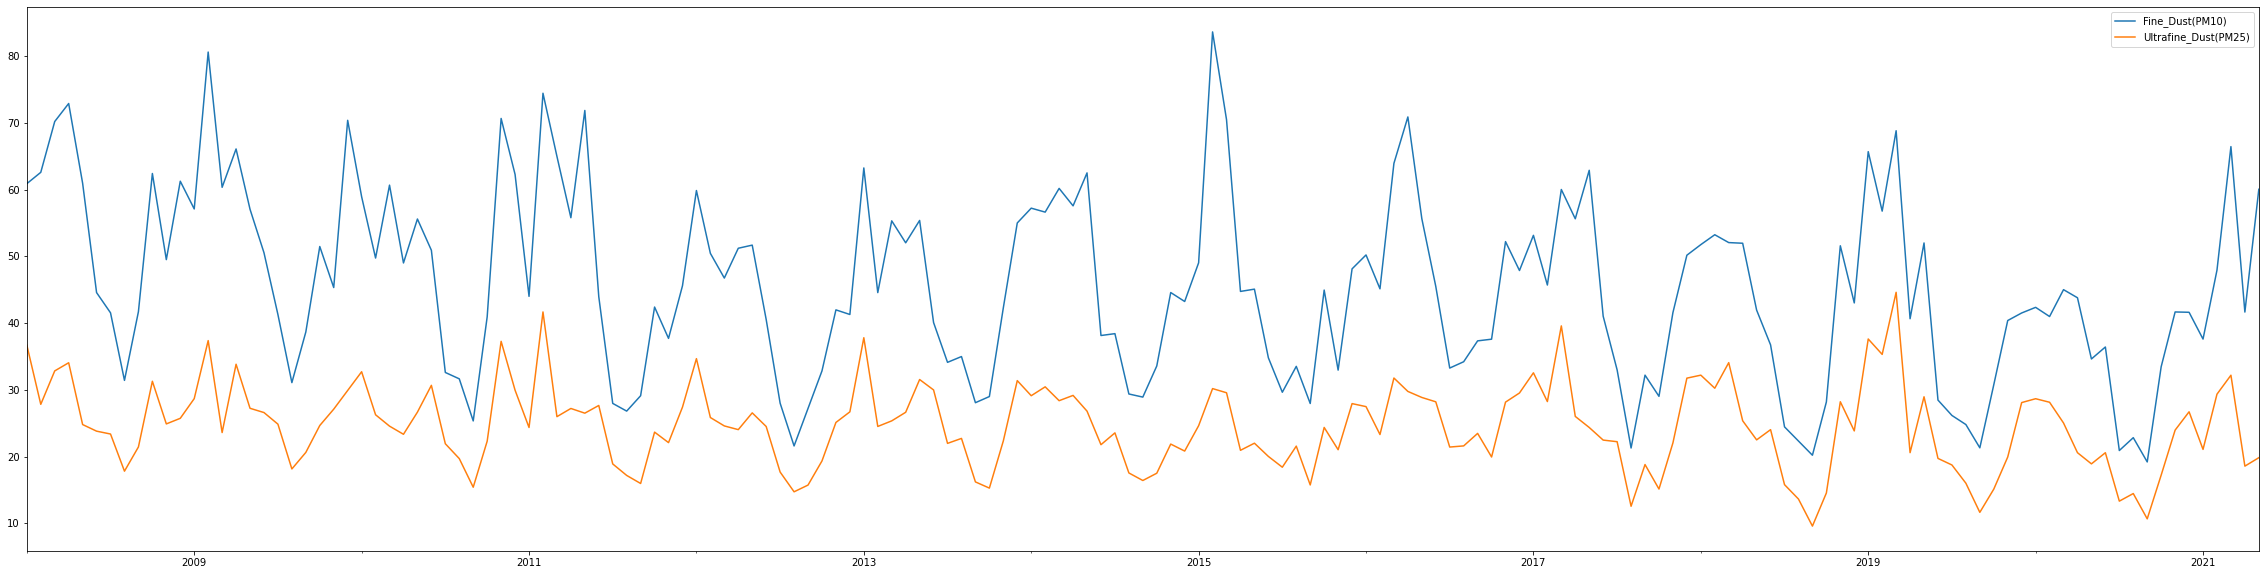

In [336]:
monthly_df.plot(figsize=(40,10))

In [337]:
annually_df = df_avg2.resample('Y').mean()
annually_df.drop(index='2021-12-31', inplace=True)
annually_df

,Fine_Dust(PM10),Ultrafine_Dust(PM25)
2008-12-31,55.002049,27.057946
2009-12-31,54.005479,26.799201
2010-12-31,49.036073,25.887329
2011-12-31,46.900799,24.764840
2012-12-31,41.088001,23.290528
2013-12-31,44.561530,25.508333
2014-12-31,45.824315,23.578425
2015-12-31,45.219863,23.015411
2016-12-31,47.804645,26.130920
2017-12-31,43.814384,24.644292


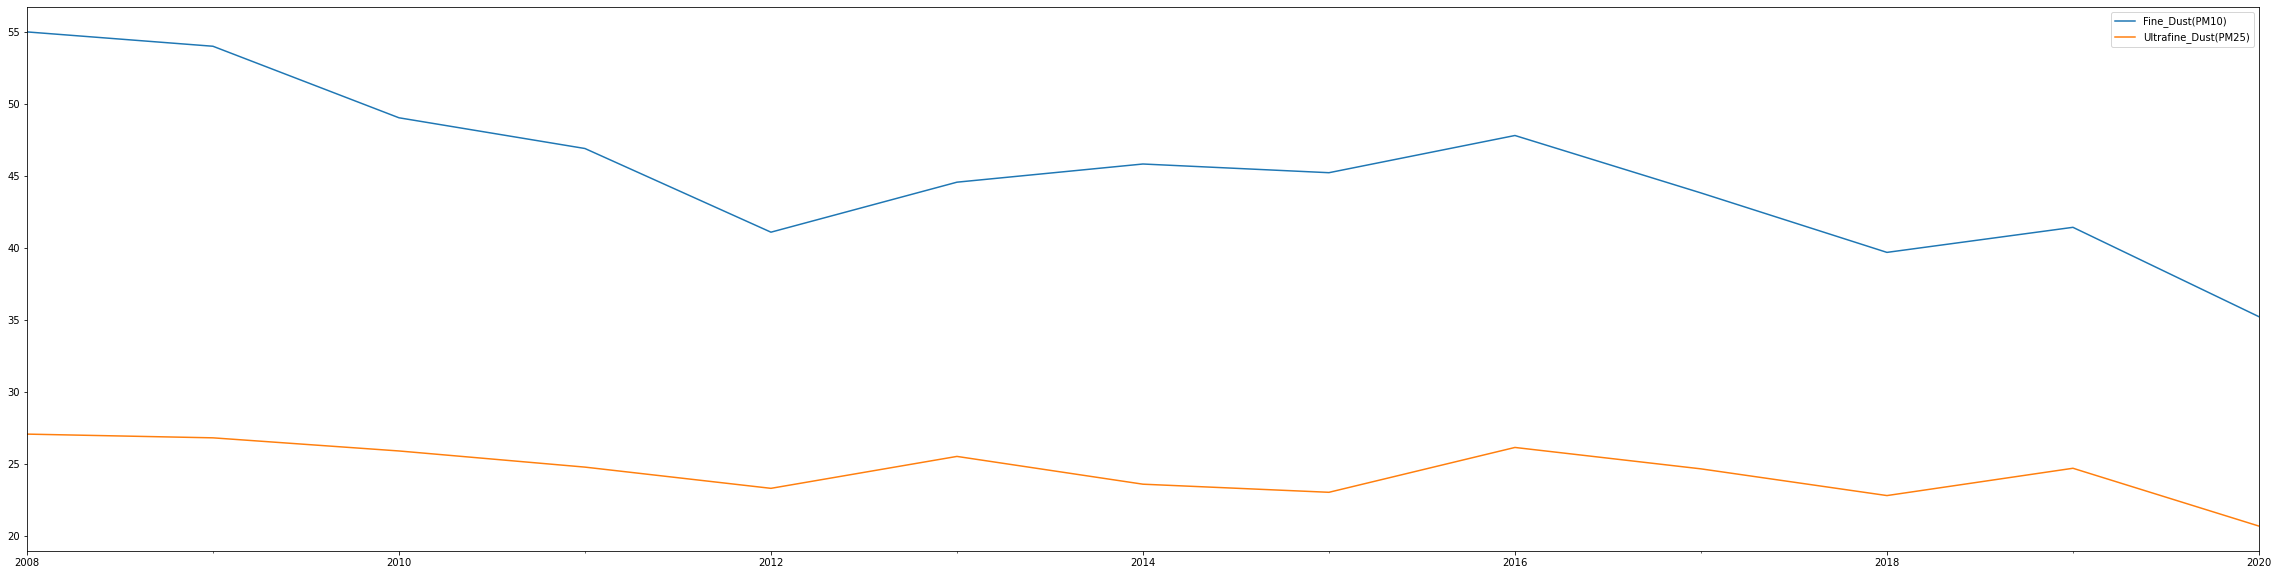

In [338]:
annually_df.plot(figsize=(40,10))

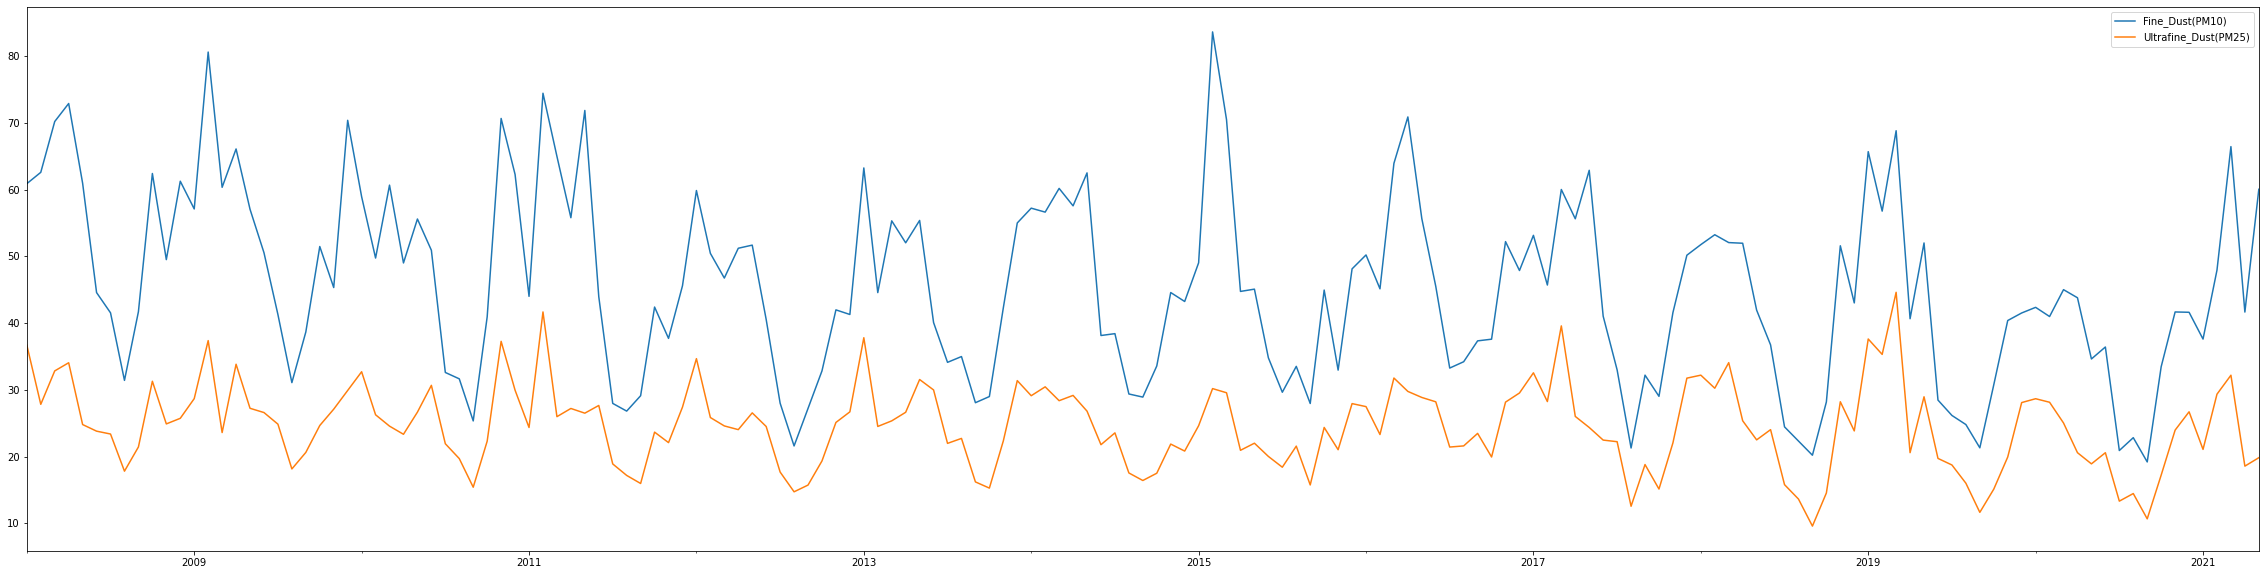

In [339]:
monthly_df = df_avg2.resample('M').mean()
monthly_df.plot(figsize=(40,10))

In [340]:
df_avg2

,Fine_Dust(PM10),Ultrafine_Dust(PM25)
2008-01-01 00:00:00,59.0,14.0
2008-01-01 01:00:00,59.0,14.0
2008-01-01 02:00:00,52.0,14.0
2008-01-01 03:00:00,49.0,14.0
2008-01-01 04:00:00,45.0,15.0
...,...,...
2021-05-31 19:00:00,45.0,25.0
2021-05-31 20:00:00,45.0,25.0
2021-05-31 21:00:00,45.0,25.0
2021-05-31 22:00:00,43.0,23.0


In [341]:
list_sum1 = []
list_sum2 = []
for j in range(24):
    list1 = []
    list2 = []
    for i in range(4900):
        list1.append( df_avg2['Fine_Dust(PM10)'][24*(i)+j].mean() )
        list2.append( df_avg2['Ultrafine_Dust(PM25)'][24*(i)+j].mean() )
    list_sum1.append(np.mean(list1))
    list_sum2.append(np.mean(list2))

In [342]:
df_fd_hour = pd.DataFrame(list_sum1, columns=['Fine_Dust(PM10)'])
df_ufd_hour = pd.DataFrame(list_sum2, columns=['Ultrafine_Dust(PM25)'])

In [343]:
df_final_hour = pd.concat([df_fd_hour,df_ufd_hour], axis=1)
df_final_hour

,Fine_Dust(PM10),Ultrafine_Dust(PM25)
0,46.268367,25.336735
1,45.653878,25.180612
2,44.624286,24.803469
3,43.638776,24.485102
4,42.509388,23.887551
5,42.123469,23.679592
6,41.841837,23.418776
7,42.373469,23.478980
8,43.088980,23.444490
9,45.087755,24.206531


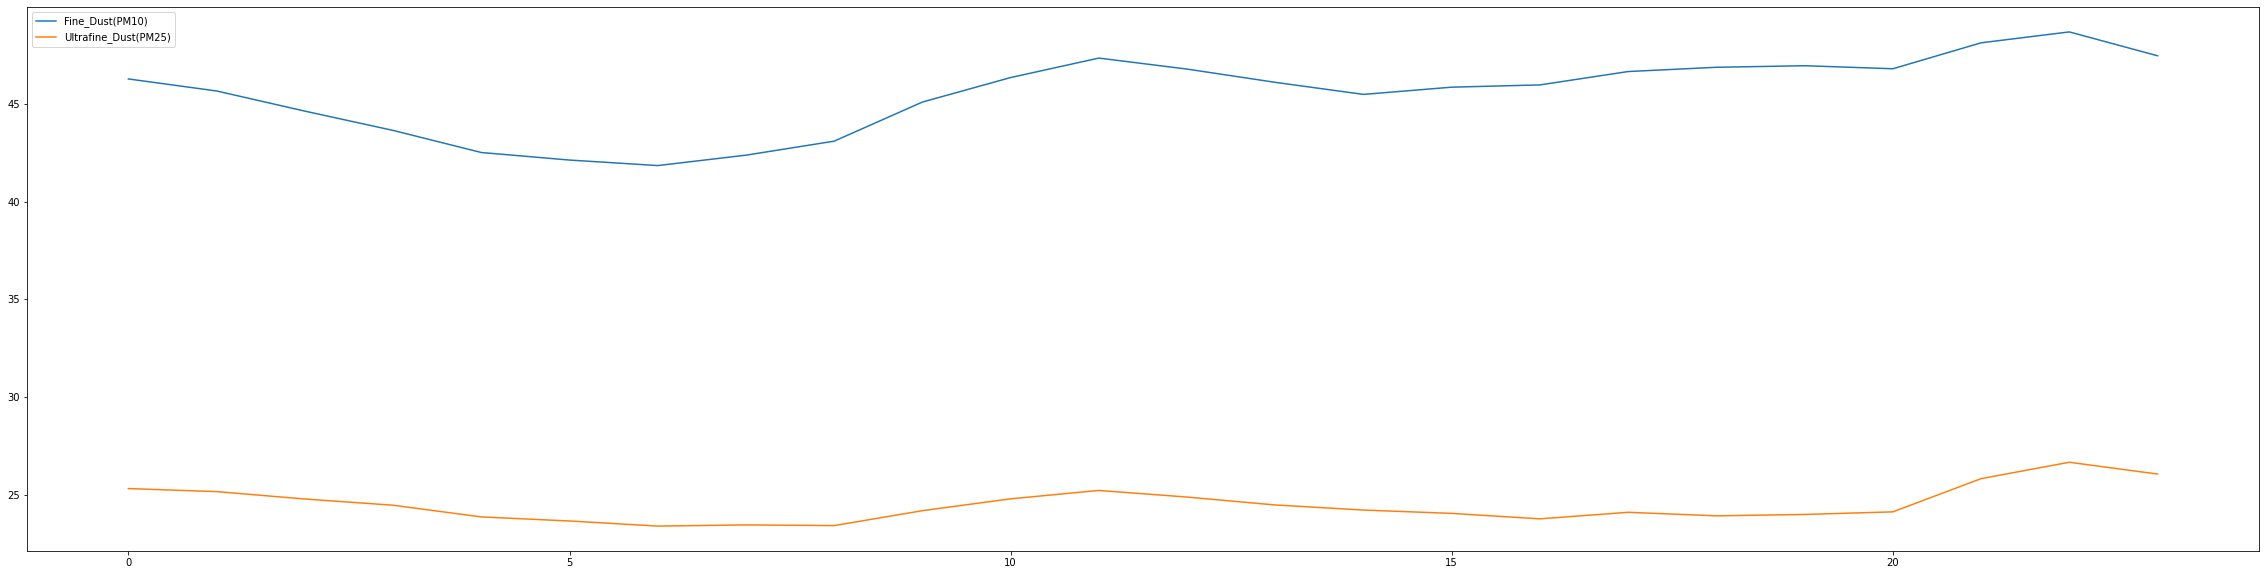

In [344]:
df_final_hour.plot(figsize=(40,10))